In [1]:
import nltk
from nltk import FreqDist
#nltk.download('stopwords') # run this one time

In [105]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

In [3]:
#df = pd.read_json('meta_AMAZON_FASHION.json', lines=True)
review = pd.read_json('AMAZON_FASHION.json', lines=True)

In [4]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


In [5]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  int64  
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   float64
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 75.0+ MB


#### From initial pass, we can see that there exist many null values in review text and summary 

Indicates that often reviewers will not leave any content in their titles or the body of reviews but simply a numerical rating

Therefore, we can simply omit tese values since we are looking investigate the actual words within the product reviews

In [6]:
review = review.dropna(subset=["reviewText"])

In [7]:
review = review.dropna(subset=["summary"])

In [8]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


### Data Preprocessing

#### Next, we investigate the frequency of word distributions, and plot them to find the most commonly used words within product reviews

In [64]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

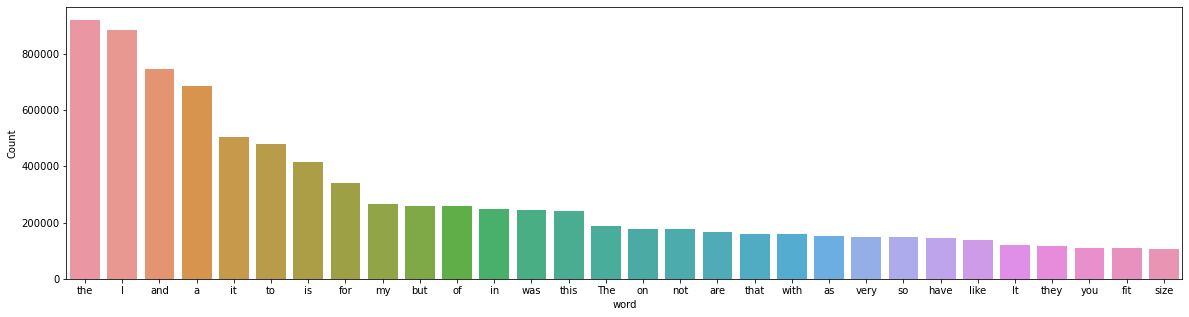

In [65]:
freq_words(review['reviewText'])

### Obviously, 'the', 'I', 'and', 'it' are most common

In [429]:
df = review['reviewText'].to_frame()
#df[['reviewText']]
df.head()

,reviewText
0,Exactly what I needed.
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...
3,too tiny an opening
4,Okay


In [430]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer 
ps = PorterStemmer()

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

### Normalizing data 
Removing special characters, punctuation and numbers, and applying lowercase to all words.

In [431]:
df['text_clean'] = df['reviewText'].str.lower()
df['text_clean'] = df['text_clean'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
df['text_clean'] = df['text_clean'].apply(lambda elem: re.sub(r"\d+", "", elem))

### Removing stop words

We chose to remove 'not' from our stopwords set as this may impact the meaning of negative reviews

Example: I did not like --> I did like

In [470]:
stop = set(stopwords.words('english'))
stop.remove('not')
##choose to remove not since it may impact the sentiment and bigram analysis

In [471]:
df['noStopword'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [472]:
df.head()

,reviewText,text_clean,noStopword,token,token_lemma,token_pos,adv_lemma
0,Exactly what I needed.,exactly what i needed,exactly needed,"[exactly, needed]","[exactly, needed]","[(exactly, RB), (needed, VBN)]","[exactly, needed]"
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back,"[agree, review, opening, small, almost, bent, hook, expensive, earrings, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[(agree, JJ), (review, NN), (opening, VBG), (small, JJ), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, NN), (theyre, NN), (...","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]"
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer,"[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earrings, dont, wish, tiny, bit, longer]","[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]","[(love, VB), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (always, RB), (losing, VBG), (back, RP), (earring, VBG), (dont, NN), (un...","[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]"
3,too tiny an opening,too tiny an opening,tiny opening,"[tiny, opening]","[tiny, opening]","[(tiny, JJ), (opening, NN)]","[tiny, opening]"
4,Okay,okay,okay,[okay],[okay],"[(okay, NN)]",[okay]


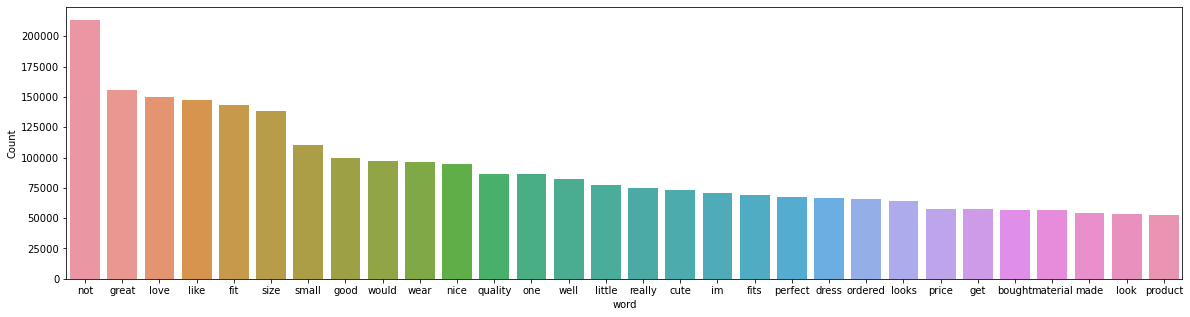

In [473]:
freq_words(df['noStopword'])

## Tokenization

Split our cleaned text into constiuent parts by breaking apart unstructured data and natural language text into chunks for analysis as individual elements. 

In [436]:
df['token'] = df['noStopword'].apply(lambda x: word_tokenize(x))

In [437]:
df.head()

,reviewText,text_clean,noStopword,token
0,Exactly what I needed.,exactly what i needed,exactly needed,"[exactly, needed]"
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back,"[agree, review, opening, small, almost, bent, hook, expensive, earrings, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]"
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer,"[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earrings, dont, wish, tiny, bit, longer]"
3,too tiny an opening,too tiny an opening,tiny opening,"[tiny, opening]"
4,Okay,okay,okay,[okay]


## Lemmatization

Process of reducing words to root form. This will reduce noise and the dimensionality of the final cleaned data for analysis. 

In [438]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

df['token_lemma'] = df['token'].apply(lambda x: word_lemmatizer(x))

In [527]:
df['clean'] = df['token_lemma'].str.join(' ')

In [528]:
df.head()

,reviewText,text_clean,noStopword,token,token_lemma,token_pos,adv_lemma,singular,clean
0,Exactly what I needed.,exactly what i needed,exactly needed,"[exactly, needed]","[exactly, needed]","[(exactly, RB), (needed, VBN)]","[exactly, needed]","[exactly, needed]",exactly needed
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back,"[agree, review, opening, small, almost, bent, hook, expensive, earrings, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[(agree, JJ), (review, NN), (opening, VBG), (small, JJ), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, NN), (theyre, NN), (...","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]",agree review opening small almost bent hook expensive earring trying get higher end theyre not seen would not buy price not sending back
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer,"[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earrings, dont, wish, tiny, bit, longer]","[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]","[(love, VB), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (always, RB), (losing, VBG), (back, RP), (earring, VBG), (dont, NN), (un...","[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]","[love, going, order, another, pack, keep, work, someone, including, alway, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]",love going order another pack keep work someone including always losing back earring dont understand fish hook earring dont wish tiny bit longer
3,too tiny an opening,too tiny an opening,tiny opening,"[tiny, opening]","[tiny, opening]","[(tiny, JJ), (opening, NN)]","[tiny, opening]","[tiny, opening]",tiny opening
4,Okay,okay,okay,[okay],[okay],"[(okay, NN)]",[okay],[okay],okay


## POS tagging and chunking

Categorising words to extract meaningful phrases from text. 

In [440]:
def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return pos_tagged_text

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christinegao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df['token_pos'] = df['token'].apply(lambda x: word_pos_tagger(x))

In [75]:
df['nouns'] = df['token_pos'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])
df['verbs'] = df['token_pos'].apply(lambda x: [word for word, tag in x if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']])

In [350]:
df['token_Count'] = df['token'].str.len()

In [340]:
# df.head()

### EDA

In [86]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

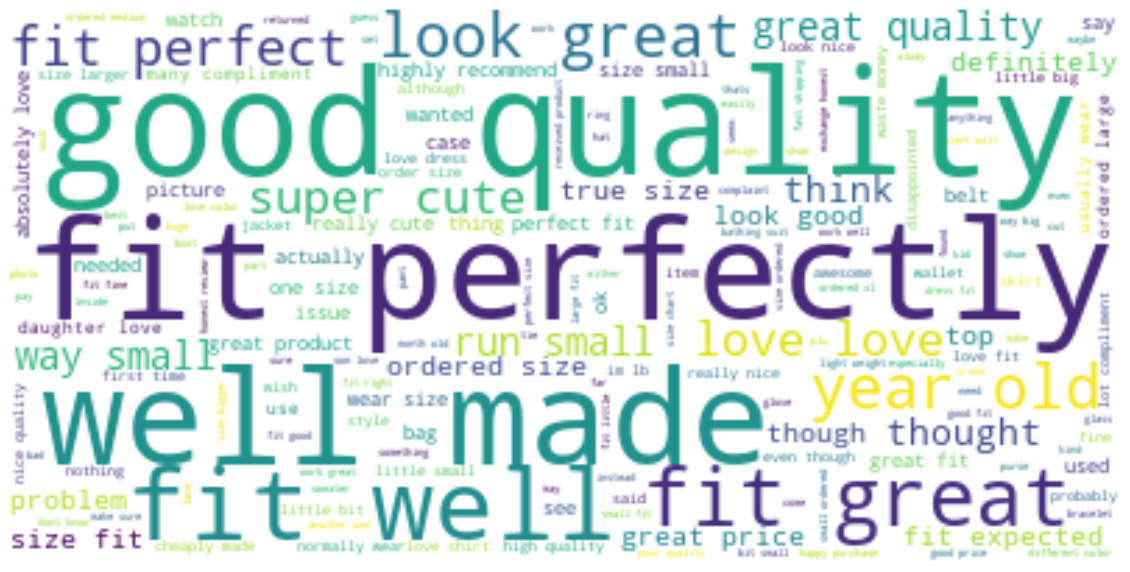

In [529]:
text = " ".join(i for i in df['clean'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Extraction

In [530]:
from nltk.collocations import *
from nltk.util import ngrams

In [531]:
word_list = ' '.join([i for i in df['clean']]).split()

In [532]:
(pd.Series(nltk.ngrams(word_list, 2)).value_counts())[:20]

(look, like)        20182
(good, quality)     18743
(fit, perfectly)    17742
(well, made)        16068
(fit, well)         15990
(fit, great)        15290
(look, great)       13214
(year, old)         12799
(like, picture)     12320
(fit, perfect)      11126
(super, cute)       10504
(love, love)        10122
(great, quality)    10096
(run, small)         9762
(way, small)         9141
(really, like)       8658
(fit, like)          8613
(fit, expected)      7968
(look, good)         7843
(great, price)       7774
dtype: int64

In [533]:
(pd.Series(nltk.ngrams(word_list, 3)).value_counts())[:20]

(look, like, picture)             4232
(love, love, love)                3073
(nothing, like, picture)          2312
(honest, unbiased, review)        2228
(would, not, recommend)           2185
(exchange, honest, review)        1947
(exchange, honest, unbiased)      1842
(would, definitely, recommend)    1802
(fit, true, size)                 1794
(discount, exchange, honest)      1790
(look, nothing, like)             1777
(im, not, sure)                   1756
(cant, wait, wear)                1731
(look, exactly, like)             1640
(exactly, like, picture)          1614
(one, size, fit)                  1603
(year, old, daughter)             1542
(received, many, compliment)      1481
(not, look, like)                 1448
(dont, waste, money)              1439
dtype: int64

In [534]:
search_word = ["love", "like", "hate", "great", "nice"] #'recommend']

no_opinion = ' '.join((filter(lambda val: val not in search_word, list(word_list)))).split()

In [535]:
(pd.Series(nltk.ngrams(no_opinion, 2)).value_counts())[:20]

(good, quality)        18848
(fit, perfectly)       17747
(fit, well)            16077
(well, made)           16069
(year, old)            12801
(fit, perfect)         11299
(super, cute)          10506
(run, small)            9768
(way, small)            9142
(look, good)            8207
(fit, expected)         8126
(ordered, size)         7781
(true, size)            7654
(size, fit)             7570
(would, not)            7288
(would, recommend)      7214
(one, size)             6412
(perfect, fit)          6245
(im, not)               6139
(highly, recommend)     6135
dtype: int64

In [536]:
(pd.Series(nltk.ngrams(no_opinion, 3)).value_counts())[:20]

(honest, unbiased, review)        2228
(would, not, recommend)           2185
(exchange, honest, review)        1947
(fit, true, size)                 1854
(exchange, honest, unbiased)      1842
(would, definitely, recommend)    1803
(discount, exchange, honest)      1790
(im, not, sure)                   1756
(cant, wait, wear)                1732
(one, size, fit)                  1614
(year, old, daughter)             1547
(received, many, compliment)      1491
(dont, waste, money)              1442
(fit, year, old)                  1428
(received, product, discount)     1419
(get, lot, compliment)            1397
(run, little, small)              1350
(got, lot, compliment)            1307
(would, highly, recommend)        1237
(not, true, size)                 1223
dtype: int64

## Sentiment Analysis

In [537]:
review['overall'].value_counts()
df['rating'] = review['overall']

In [538]:
def label_func(rating):
    if rating <= 2:
        return 'negative'
    if rating >= 4:
        return 'positive'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(label_func)

In [539]:
positive_review = df[(df["sentiment"] == 'positive')]['clean'].to_frame()
neutral_review = df[(df["sentiment"] == 'neutral')]['clean'].to_frame()
negative_review = df[(df["sentiment"] == 'negative')]['clean'].to_frame()

In [540]:
pos_clean = ' '.join([i for i in positive_review['clean']]).split()
neutral_clean = ' '.join([i for i in neutral_review['clean']]).split()
neg_clean = ' '.join([i for i in negative_review['clean']]).split()

In [541]:
pos_clean = ' '.join((filter(lambda val: val not in search_word, list(pos_clean)))).split()
neutral_clean = ' '.join((filter(lambda val: val not in search_word, list(neutral_clean)))).split()
neg_clean = ' '.join((filter(lambda val: val not in search_word, list(neg_clean)))).split()

In [542]:
n_gram_pos = (pd.Series(nltk.ngrams(pos_clean, 3)).value_counts()).to_frame()
n_gram_pos['sentiment'] = 'positive'

In [543]:
n_gram_neg = (pd.Series(nltk.ngrams(neg_clean, 3)).value_counts()).to_frame()
n_gram_neg['sentiment'] = 'negative'

n_gram_sent = pd.concat([n_gram_pos[:10], n_gram_neg[:10]])

In [544]:
n_gram_sent = n_gram_sent.rename({0: 'frequency'}, axis='columns')
n_gram_sent = n_gram_sent.sort_values(by=['frequency'], ascending=False)
n_gram_sent = n_gram_sent.reset_index()
n_gram_sent = n_gram_sent.rename({'index': 'words'}, axis='columns')

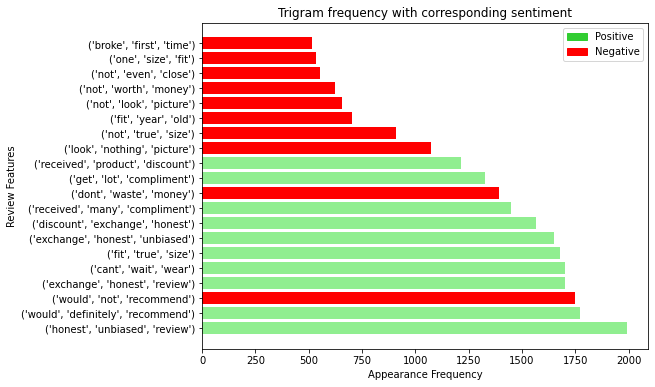

In [545]:
top_n = n_gram_sent[:25]
#top_n.info()
clrs = ['lightgreen' if (x == 'positive') else 'red' for x in top_n['sentiment']]
import matplotlib.patches as mpatches


plt.figure(figsize=(8, 6))
plt.barh([str(i) for i in top_n['words']], top_n['frequency'], color=clrs)
plt.title('Trigram frequency with corresponding sentiment')
plt.xlabel('Appearance Frequency')
plt.ylabel('Review Features')
red_patch = mpatches.Patch(color='limegreen', label='Positive')
green_path = mpatches.Patch(color='red', label='Negative')
plt.legend(handles=[red_patch, green_path])
plt.show()


In [546]:
text_corpus_positive_review = ' '.join(pos_clean)
text_corpus_neutral_review = ' '.join(neutral_clean)
text_corpus_negative_review = ' '.join(neg_clean)

In [547]:
def most_common_word_func(text, n_words=25):
    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    n_words = n_words
    df_fdist = pd.DataFrame({'Word': fdist.keys(),'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)
    
    return df_fdist

In [ ]:
df_most_common_words_text_corpus_positive_review = most_common_word_func(text_corpus_positive_review)
df_most_common_words_text_corpus_neutral_review = most_common_word_func(text_corpus_neutral_review)
df_most_common_words_text_corpus_negative_review = most_common_word_func(text_corpus_negative_review)

In [ ]:
splited_data = [df_most_common_words_text_corpus_positive_review,
                df_most_common_words_text_corpus_neutral_review,
                df_most_common_words_text_corpus_negative_review]

color_list = ['green', 'cyan', 'red']
title_list = ['Positive Review', 'Neutral Review', 'Negative Review']

In [ ]:
for item in range(3):
    plt.figure(figsize=(11,7))
    plt.barh(splited_data[item]['Word'], 
            splited_data[item]['Frequency'],
            color=color_list[item])
    plt.xlabel('Most common Words')
    plt.ylabel("Frequency")
    plt.title("Frequency distribution of the 25 most common words")
    plt.suptitle(title_list[item], fontsize=15)
    plt.show()